## Pip Installs

In [ ]:
!pip install pickle5
!pip install moviepy
!pip install tensorflow-io


## Libraries

In [3]:
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.applications import vgg19
import bz2
import matplotlib.pyplot as plt
from moviepy.audio.AudioClip import AudioArrayClip
import pickle5 as pickle
from scipy.io.wavfile import write

# colab imports
from google.colab import drive

## Input Pipeline

In [4]:
# Load any compressed pickle file
def decompress_pickle(file):
    data = bz2.BZ2File(file, "rb")
    data = pickle.load(data)
    return data

### Mounting google drive

In [5]:
drive.mount("/content/drive/")

audio_raw = decompress_pickle("/content/drive/MyDrive/Iannwtf_final_project/data/dataset_audio_medium.pbz2")[100]
images_raw = decompress_pickle("/content/drive/MyDrive/Iannwtf_final_project/data/dataset_images_medium.pbz2")[100]

print(audio_raw.shape)
print(images_raw.shape)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(1, 48000)
(9, 96, 170, 3)


### Preprocessing

In [6]:
group_length = 500
batch_size = 1

image_shape = None
enc_seq_len = None
dec_seq_len = None

In [7]:
audio_raw = tf.expand_dims(audio_raw,0)
audio_raw.shape

images_raw = tf.expand_dims(images_raw,0)
images_raw.shape

TensorShape([1, 9, 96, 170, 3])

In [8]:
# add start and end tokens
token = np.zeros([*audio_raw.shape[0:2], group_length])

audio_raw = np.concatenate((token, audio_raw, token), axis = 2)

In [9]:
# normalize audio to the same volume
def normalize_audio(audio):
    return audio/tf.reduce_max(tf.abs(audio))

# group audio
def group_audio(audio):
    return tf.reshape(audio, (-1, group_length))


# normalize images and switch color channels
def normalize_images(image):
    return vgg19.preprocess_input(image)

In [10]:
audio_raw.shape

(1, 1, 49000)

In [11]:
dataset_images = tf.data.Dataset.from_tensor_slices(images_raw)
dataset_audio = tf.data.Dataset.from_tensor_slices(audio_raw)

dataset = tf.data.Dataset.zip((dataset_images, dataset_audio))
dataset = dataset.map(lambda image, audio: (normalize_images(image), group_audio(normalize_audio(audio))), num_parallel_calls=tf.data.experimental.AUTOTUNE)#.cache()

dataset = dataset.shuffle(buffer_size=batch_size)
dataset = dataset.batch(batch_size=batch_size)

dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
for elem in dataset:
    enc_seq_len = elem[0].shape[1]
    dec_seq_len = elem[1].shape[1] - 1
    image_shape = elem[0].shape[2:]
    print(elem[0].shape)
    print(elem[1].shape)
    break

(1, 9, 96, 170, 3)
(1, 98, 500)


## Feature Extractor

In [13]:
# VGG19 model pretrained on imagenet
class FeatureExtractor(Model):
    def __init__(self, image_shape):
        super(FeatureExtractor, self).__init__()
        # Init the VGG model
        self.model = vgg19.VGG19(weights='imagenet', include_top=False, input_shape=image_shape, pooling='avg')
    
    def freeze(self):
        for layer in self.model.layers:
            layer.trainable = False

    def unfreeze(self):
        for layer in self.model.layers:
            layer.trainable = True

    def call(self, frame):
        return self.model(frame)

## Scaled Dot Product Attention

In [14]:
def scaled_dot_product_attention(query, key, value, mask):

    scores = tf.matmul(query, key, transpose_b=True) / tf.math.sqrt(tf.cast(key.shape[-1],tf.float32))

    # Add the mask to the scaled tensor
    if mask is not None:
        scores += (mask * -1e9)  

    attention_weights = tf.nn.softmax(scores)

    output = attention_weights @ value

    return output

##  Multi Head Attention

In [15]:
class MultiHeadAttention(Layer):
    def __init__(self, model_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.model_dim = model_dim
        
        assert model_dim % num_heads == 0

        self.head_dim = model_dim // num_heads

        self.wq = tf.keras.layers.Dense(model_dim)
        self.wk = tf.keras.layers.Dense(model_dim)
        self.wv = tf.keras.layers.Dense(model_dim)

        self.wo = tf.keras.layers.Dense(model_dim)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.head_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x, mask, **kwargs):
        batch_size = x.shape[0]

        query = self.wq(x)  # (batch_size, seq_len, model_dim)
        if 'encoder_out' in kwargs:
            key = self.wk(kwargs['encoder_out'])
            value = self.wv(kwargs['encoder_out'])
        else:
            key = self.wk(x)
            value = self.wv(x)

        # Split up the heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # attention.shape == (batch_size, num_heads, seq_len, head_dim)
        attention = scaled_dot_product_attention(query, key, value, mask)

        # Concatenate heads back together
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len, num_heads, head_dim)
        attention = tf.reshape(attention,(batch_size, -1, self.model_dim))  # (batch_size, seq_len, model_dim)

        output = self.wo(attention)  # (batch_size, seq_len, output_dim)

        return output

## Positional Encodings

In [16]:
def positional_encoding(seq_len, model_dim):
    pos = np.expand_dims(np.arange(seq_len),1)
    i = np.expand_dims(np.arange(model_dim),0)
    angle_rads = pos/(10000**(2*(i//2)/model_dim))

    # Apply sin to even indices in the array
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # Apply cos to odd indices in the array
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    # Add batch dimension
    pos_encoding = np.expand_dims(angle_rads,0)

    return tf.cast(pos_encoding, dtype=tf.float32)

## Look ahead Mask

In [17]:
def look_ahead_mask(size):
    mask = np.triu(np.ones((size, size)),1)
    return mask

## Encoder Layer

In [18]:
class EncoderLayer(Layer):
    def __init__(self, model_dim, num_heads, ffn_units, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization()

        self.feedForward = [
            tf.keras.layers.Dense(ffn_units, activation='relu'),
            tf.keras.layers.Dense(model_dim)
        ]
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
    
    def call(self, x, mask, training = False):
        attention_out = self.attention(x, mask)
        attention_out = self.dropout_1(attention_out,training=training)
        x = self.layernorm_1(x + attention_out)

        feedForward_out = x
        for layer in self.feedForward:
            feedForward_out = layer(feedForward_out)
        feedForward_out = self.dropout_2(feedForward_out, training=training)
        x = self.layernorm_2(x + feedForward_out)

        return x

## Decoder Layer

In [19]:
class DecoderLayer(Layer):
    def __init__(self, model_dim, num_heads, ffn_units, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_1 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_1 = tf.keras.layers.LayerNormalization()

        self.enc_dec_attention = MultiHeadAttention(model_dim, num_heads)
        self.dropout_2 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_2 = tf.keras.layers.LayerNormalization()

        self.feedForward = [
            tf.keras.layers.Dense(ffn_units, activation='relu'),
            tf.keras.layers.Dense(model_dim)
        ]
        self.dropout_3 = tf.keras.layers.Dropout(dropout_rate)
        self.layernorm_3 = tf.keras.layers.LayerNormalization()
    
    def call(self, x, enc_out, mask, training = False):
        attention_out = self.attention(x, mask)
        attention_out = self.dropout_1(attention_out,training=training)
        x = self.layernorm_1(x + attention_out)

        enc_dec_attention_out = self.enc_dec_attention(x, mask=None, encoder_out=enc_out)
        enc_dec_attention_out = self.dropout_2(enc_dec_attention_out,training=training)
        x = self.layernorm_2(x + enc_dec_attention_out)

        feedForward_out = x
        for layer in self.feedForward:
            feedForward_out = layer(feedForward_out)
        feedForward_out = self.dropout_3(feedForward_out, training=training)
        x = self.layernorm_3(x + feedForward_out)

        return x

## Encoder

In [20]:
class Encoder(Layer):
    def __init__(self, num_layers, model_dim, num_heads, ffn_units, image_shape, seq_len, dropout_rate):
        super(Encoder, self).__init__()
        self.image_shape = image_shape

        self.embedding = FeatureExtractor(image_shape)
        self.dense = tf.keras.layers.Dense(model_dim)
        self.pos_encoding = positional_encoding(seq_len,model_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.enc_layers = [EncoderLayer(model_dim,num_heads,ffn_units,dropout_rate) for _ in range(num_layers)]

    def freeze_vgg(self):
        self.embedding.freeze()

    def unfreeze_vgg(self):
        self.embedding.unfreeze()

    def call(self, x, mask, training=False):
        batch_size = x.shape[0]
        seq_len = x.shape[1]

        # Concatenate batch size and sequence length
        x = tf.reshape(x,(-1,*self.image_shape))
        x = self.embedding(x)
        x = tf.reshape(x,(batch_size, seq_len, -1))
        x = self.dense(x)
        x += self.pos_encoding

        x = self.dropout(x, training=training)

        for layer in self.enc_layers:
            x = layer(x, mask, training)

        return x

## Decoder

In [21]:
class Decoder(Layer):
    def __init__(self, num_layers, model_dim, num_heads, ffn_units, seq_len, dropout_rate):
        super(Decoder, self).__init__()

        self.embedding = tf.keras.layers.Dense(model_dim)
        self.pos_encoding = positional_encoding(seq_len,model_dim)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

        self.dec_layers = [DecoderLayer(model_dim,num_heads,ffn_units,dropout_rate) for _ in range(num_layers)]

    def call(self, x, enc_out, mask, training=False):
        seq_len = x.shape[1]


        x = self.embedding(x)
        x += self.pos_encoding[:, :seq_len]

        x = self.dropout(x, training=training)

        for layer in self.dec_layers:
            x = layer(x, enc_out, mask, training)

        return x

## Transformer

In [22]:
class Transformer(Model):
    def __init__(self, num_enc_layers, num_dec_layers, model_dim, num_heads, ffn_units, image_shape, enc_seq_len, dec_seq_len, output_depth, dropout_rate):
        super(Transformer, self).__init__()

        self.encoder = Encoder(num_enc_layers, model_dim, num_heads, ffn_units, image_shape, enc_seq_len, dropout_rate)
        self.decoder = Decoder(num_dec_layers, model_dim, num_heads, ffn_units, dec_seq_len, dropout_rate)

        self.output_layer = tf.keras.layers.Dense(output_depth, activation='tanh')

    def freeze_vgg(self):
        self.encoder.freeze_vgg()

    def unfreeze_vgg(self):
        self.encoder.unfreeze_vgg()
    
    def call(self, x, target, mask=None, training=False):
        encoder_out = self.encoder(x, mask=None, training=training)
        decoder_out = self.decoder(target, encoder_out, mask, training=training)
        output = self.output_layer(decoder_out)

        return output

## Training Step

In [23]:
loss_function = tf.keras.losses.MeanSquaredError()

def tf_specto_loss(target, prediction):
    target = tf.reshape(target, shape=-1)
    prediction = tf.reshape(prediction, shape=-1)

    spectrogram_target = tfio.experimental.audio.spectrogram(target, nfft=512, window=512, stride=256)
    spectrogram_prediction = tfio.experimental.audio.spectrogram(prediction, nfft=512, window=512, stride=256)

    return loss_function(spectrogram_target, spectrogram_prediction)


In [ ]:
audio_samples = []

for input_seq, target_seq in dataset.take(3):
    audio_samples.append(target_seq)
   
tf_specto_loss(audio_samples[0], audio_samples[1])

In [25]:
#@tf.function
def train_step(model, input_seq, target_seq, mask, loss_function, optimizer_fe, optimizer_tr):
    target_seq_prior = target_seq[:, :-1]
    target_seq_posterior = target_seq[:, 1:]

    with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2:        
        pred = model(input_seq, target_seq_prior, mask, training=True)
        #loss = loss_function(target_seq_posterior, pred)
        #print(loss.eval)
        #loss = loss_function_spectogramm(target_seq_posterior, pred) 
        loss = tf_specto_loss(target_seq_posterior, pred)  
        #print(loss_2.eval, "\n")
        gradients_fe = tape_1.gradient(loss, model.encoder.embedding.trainable_variables)
        gradients_tr = tape_2.gradient(loss, [layer for layer in model.trainable_variables if "conv" not in layer.name])

    optimizer_fe.apply_gradients(zip(gradients_fe, model.encoder.embedding.trainable_variables)) # train feature extractor
    optimizer_tr.apply_gradients(zip(gradients_tr, [layer for layer in model.trainable_variables if "conv" not in layer.name])) # train other layers

    return loss

## Train Model

In [ ]:
for input_seq, target_seq in dataset:
    print(input_seq.shape)
    print(target_seq.shape)
    break

(1, 96, 170, 3)
(1, 98, 500)


In [26]:
def train_model(model, dataset, loss_function, optimizer_fe, optimizer_tr, num_epochs):
    running_average_factor = 0.95

    # create mask
    mask = look_ahead_mask(size = dec_seq_len)

    # Initialize lists for later visualization.
    train_losses = []
    
    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
            
        # Training
        running_average_loss = 0
        for input_seq, target_seq in dataset:
            train_loss = train_step(model, input_seq, target_seq, mask, loss_function, optimizer_fe, optimizer_tr)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss

        train_losses.append(running_average_loss.numpy())

        visualize_progress(num_epochs, epoch, train_losses)

        # test audio

        # Display loss and accuracy for current epoch    
        print(f'Epoch: __ {epoch+1}')
        print('Train loss: ',running_average_loss.numpy())

In [27]:
from IPython.display import clear_output

def visualize_progress(num_epochs, epoch, train_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,5))
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    plt.show()

## Train BIBO

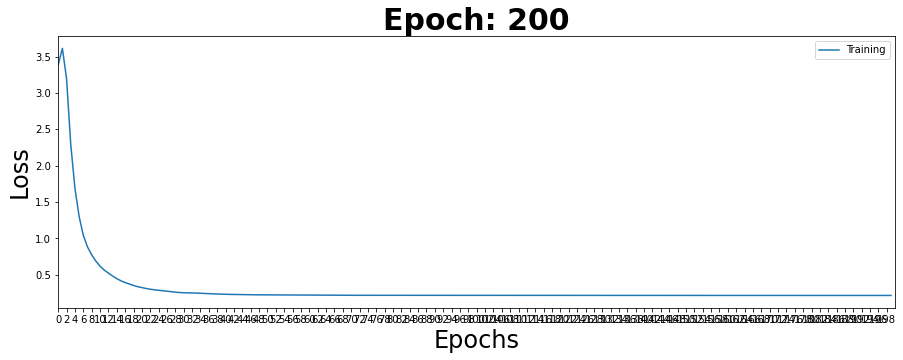

Epoch: __ 200
Train loss:  0.21682441


In [28]:
#%%time
tf.keras.backend.clear_session()

learning_rate_fe = 0.00001
learning_rate_tr = 0.0001

num_enc_layers = 32
num_dec_layers = 32
model_dim = 1024
num_heads = 8
ffn_units = 2048
output_depth = group_length
dropout_rate = 0.0
epochs = 200

# Initialize the loss
loss_function = tf.keras.losses.MeanSquaredError()

# Initialize the optimizer
optimizer_fe = tf.keras.optimizers.Adam(learning_rate_fe)
optimizer_tr = tf.keras.optimizers.Adam(learning_rate_tr)


# Initialize model
BIBO = Transformer(num_enc_layers, num_dec_layers, model_dim, num_heads, ffn_units, image_shape, enc_seq_len, dec_seq_len, output_depth, dropout_rate)

train_model(
    model = BIBO,
    dataset = dataset,
    loss_function = loss_function,
    optimizer_fe = optimizer_fe,
    optimizer_tr = optimizer_tr,
    num_epochs = epochs
)

## Evaluate

In [29]:
def evaluate(frames):

    output = tf.zeros([1, 1, group_length])

    for i in range(dec_seq_len):
        mask = look_ahead_mask(output.shape[1])
        audio_prediction = BIBO(frames, output, mask)
        output = tf.concat([output, audio_prediction[:, -1:, :]], axis=1)

    output = tf.reshape(output, shape=(output.shape[0], -1))

    return output

In [28]:
images_raw.shape

TensorShape([1, 9, 96, 170, 3])

In [31]:
audio = evaluate(tf.expand_dims(images_raw[0], 0))

audio_stereo = tf.concat([audio, audio], axis=0).numpy().reshape((-1, 2))

write('test_5.wav', 16000, audio[0].numpy())

# audio_file = AudioArrayClip(audio_stereo, fps=16000)
# audio_array = audio_file.to_soundarray()
# audio_file.write_audiofile('stereo_2.mp3')

In [31]:
audio[0].shape

TensorShape([49000])

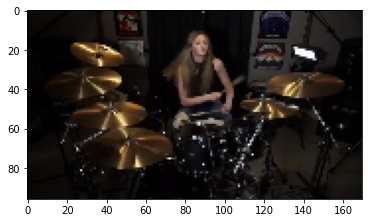

In [ ]:
#plt.imshow(images_raw[0, 0])
plt.imshow(images_raw[0])

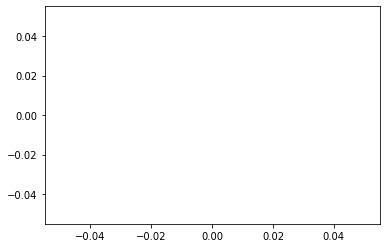

In [34]:
plt.plot(audio[0][1000:100].numpy())

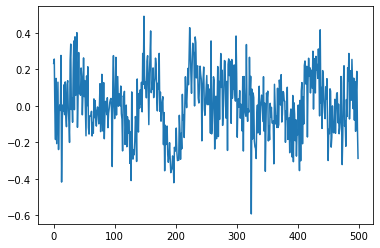

In [33]:
plt.plot(audio_raw[0,0][1000:1500])


(49000,)
(49000,)
(49000, 2)
[MoviePy] Writing audio in stereo6.mp3


100%|██████████| 25/25 [00:00<00:00, 109.13it/s]

[MoviePy] Done.


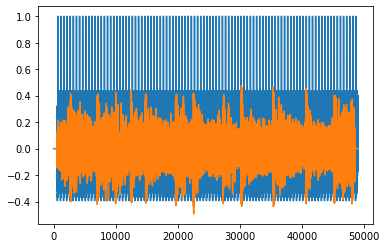

In [35]:
og_audio =  0.4*audio_raw[0,0]
new_audio = audio[0]

print(og_audio.shape)
print(new_audio.shape)

audio_stereo = np.concatenate([np.expand_dims(new_audio, -1), np.expand_dims(og_audio, -1)], axis = 1)
plt.plot(audio_stereo)
print(audio_stereo.shape)
audio_file = AudioArrayClip(audio_stereo, fps=16000)
audio_file.write_audiofile('stereo6.mp3')